In [2]:
import os
from PIL import Image, ImageEnhance, ImageOps
import random
from random import randint
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import tensorflow as tf;
import time
print(tf.version)

export_conf_limit = 0#0.98

%matplotlib inline

input_aspect = 42.0 / 30.0 
input_width = 28
input_height = 28
output_classes = 11

regions = [
    [17 + 37 * 0, 132, 30, 42],
    [17 + 37 * 1, 132, 30, 42],
    [17 + 38 * 2, 134, 30, 42],
    [17 + 38 * 3, 134, 30, 42],
    [17 + 38 * 4, 135, 30, 42],
    [17 + 38 * 5, 135, 30, 42],
    [17 + 38 * 6, 135, 30, 42],
]

interpreter = tf.lite.Interpreter(model_path="ocr_model_28x28_c11.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
#print("INPUT: " + str(input_details))
output_details = interpreter.get_output_details()
#print("OUTPUT: " + str(output_details))

def convert_image(image):
    # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize
    image = image.resize((input_width, input_height), Image.NEAREST)
    image = image.convert("L")
    image = np.asarray(image)
    return np.asarray(image).astype(np.float32) / 255.

def load_image(filePath):
    image = Image.open(filePath)
    return convert_image(image)

def predict(img):
    input_shape = input_details[0]['shape']
    input_data = img.reshape(1, img.shape[0], img.shape[1], 1)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    result = interpreter.get_tensor(output_details[0]['index'])
    raw_pred = np.argmax(result, axis = 1)[0]
    raw_conf = result[0][raw_pred]
    result[0][10] = 0.0 # set garbage class to confidence = 0
    digit_pred = np.argmax(result, axis = 1)[0]
    digit_conf = result[0][digit_pred]
    return ((digit_pred, digit_conf), (raw_pred, raw_conf))

def predict_camera_image(filePath, verbose = False):
    if verbose:
        print(filePath)
    image = Image.open(filePath)
    value = 0.0
    conf = 1.0
    valid = True
    i = 0
    for region in regions:
        raw_digit_img = image.crop((region[0], region[1], region[0] + region[2], region[1] + region[3]))
        digit_img = convert_image(raw_digit_img)
        pred = predict(digit_img)
        digit_pred = pred[0]
        raw_pred = pred[1]
        conf = min(conf, digit_pred[1]);
        value = value + pow(10, 5 - i) * digit_pred[0];
        valid = valid and (digit_pred[0] == raw_pred[0])
        i = i + 1
        if raw_pred[1] < export_conf_limit:
            didPath = "images/cropped/" + str(raw_pred[0])
            try:
                os.mkdir(didPath)
            except FileExistsError:
                pass
            raw_digit_img.save(didPath + "/" + "{:03d}".format(int(100 * raw_pred[1])) + "_" + str(time.time()) + ".png")
        
    result = (value, conf, valid)
    if verbose:
        print(result)
        plt.imshow(image)
        plt.show()
    return result

def predict_camera_images(srcPath, verbose = False):
    files = os.listdir(srcPath)    
    files = [file for file in files if file[-4:] == ".jpg"]
    results = {}
    for file in files:
        filePath = srcPath + "/" + file
        try:
            pred = predict_camera_image(filePath, verbose)
            results[file] = pred
        except OSError as err:
            print(str(err))
    return results

<module 'tensorflow._api.v2.version' from 'C:\\Anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [2]:
img = load_image('images/labeled/10/x207_y135_62_3983665_img.png')

pred = predict(img)
print(pred)

((7, 0.0023195075), (10, 0.9976768))


images/captured/80_2261164_img.jpg
(13859.9, 0.9989503, True)


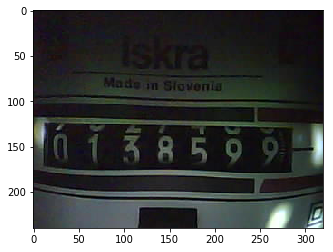

(13859.9, 0.9989503, True)

In [14]:
predict_camera_image('images/captured/80_2261164_img.jpg', True)


In [3]:
preds = predict_camera_images('images/captured/', False)

In [4]:
min_valid_conf = 1.0
avg_valid_conf = 0
num_valid = 0
num_invalid = 0
for k, v in preds.items():
    if v[2]:
        num_valid = num_valid + 1
        min_valid_conf = min(min_valid_conf, v[1])
        avg_valid_conf = avg_valid_conf + v[1]
    else:
        num_invalid = num_invalid + 1

avg_valid_conf = avg_valid_conf / num_valid
num_total = num_valid + num_invalid
print("valid: " + str(round(100 * num_valid / num_total)) + "% min_conf: " + str(min_valid_conf) + " avg_conf: " + str(avg_valid_conf))
#print("invalid: " + str(round(100 * num_invalid / num_total)) + "%")

valid: 64% min_conf: 0.3874344 avg_conf: 0.9659332997398176
